Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


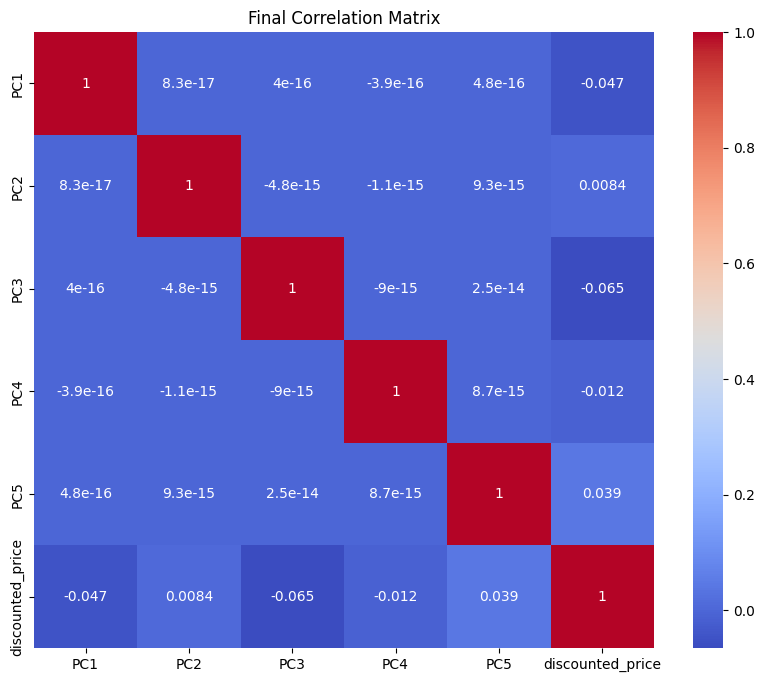

Saved to /content/drive/My Drive/PGNO-190/final_preprocessed.csv


In [10]:
# --- Group Pipeline ---

# Mount Drive and imports
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Load raw
df = pd.read_csv('/content/drive/My Drive/PGNO-190/amazon.csv')
df = df[df['category'].str.contains('Computers&Accessories', na=False)].copy()

# Clean numerical columns
for col in ['discounted_price', 'actual_price', 'discount_percentage', 'rating_count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].str.replace('₹', '').str.replace(',', '').str.replace('%', '', regex=False), errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# --- Member 1: Handling Missing Data (Luxsana S.) ---
# Justification: Impute missing values to avoid bias in price prediction.
num_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())
text_cols = ['about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# --- Member 2: Encoding Categorical Variables (Balasooriya B.K.N.N) ---
# Justification: Encode 'category' for ML compatibility.
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'].fillna('Unknown'))

# --- Member 3: Outlier Removal (Munasinghe D.D.T) ---
# Justification: Remove outliers in 'discounted_price' to improve model robustness.
Q1 = df['discounted_price'].quantile(0.25)
Q3 = df['discounted_price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['discounted_price'] < (Q1 - 1.5 * IQR)) | (df['discounted_price'] > (Q3 + 1.5 * IQR)))]

# --- Member 4: Normalization / Scaling (Sulochana D.A.C) ---
# Justification: Scale numerical features for balanced model input.
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols].fillna(0))

# --- Member 5: Feature Selection (Hettige S.L) ---
# Justification: Remove irrelevant features to reduce noise.
irrelevant_cols = ['img_link', 'product_link', 'user_id', 'review_id', 'product_id']
df = df.drop(columns=irrelevant_cols, errors='ignore')

# --- Member 6: Dimension Reduction (Thewsara E.J.K.P.D) ---
# Justification: Reduce dimensions with PCA for efficiency. Non-numerical columns must be excluded as PCA requires numerical input.
X = df.drop('discounted_price', axis=1)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X = X[numerical_cols]  # Use only numerical columns
y = df['discounted_price']
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X)
df_reduced = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(5)])
df_reduced['discounted_price'] = y

# Final EDA
plt.figure(figsize=(10,8))
sns.heatmap(df_reduced.corr(), annot=True, cmap='coolwarm')
plt.title('Final Correlation Matrix')
plt.savefig('/content/final_correlation.png')
plt.show()

# Interpretation: The heatmap shows correlations between principal components and the target, reflecting the reduced dataset's structure with 80-90% variance retained from the PCA.

# Save
final_path = '/content/drive/My Drive/PGNO-190/final_preprocessed.csv'
df_reduced.to_csv(final_path, index=False)
print(f'Saved to {final_path}')